In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
print(tf.__version__)

2.0.0


텐서플로는 노드 집합으로 구성된 계산 그래프를 바탕으로 한다. 각 노드는 0 개 이상의 입력이나 출력을 가지는 연산을 나타낸다.
계산 그래프의 에지를 따라 이동하는 값을 텐서라고 한다.

텐서플로 1.5.0 버전에서는 계산 그래프를 만들지 않고 텐서를 즉시 평가할 수 있는 즉시 실행 기능이 추가되었다.
텐서플로 2,x에서는 즉시 실행 모드가 기본으로 활성화되어 있어서 텐서 값을 바로 확인할 수 있다.

텐서는 스칼라, 벡터, 행렬 등이 일반화된 것으로 생각할 수 있다.

텐서플로 1.x에서는 계산 그래프가 굿어된 후 텐서플로의 Sessio을 통해 그래프에 있는 각 노드를 실행한다.
텐서플로 2.x버전에서 이와 관련된 연산은 tensorflow.compat.v1으로 이동되었다.


## tensorflow 1 구현

In [2]:
g = tf.Graph()
with g.as_default():
    x = tf.compat.v1.placeholder(dtype = tf.float32, shape=(None ), name='x')
    w = tf.Variable(2.0, name='weight')
    b = tf.Variable(0.7, name='bias')
    
    z = w *x + b
    
    init = tf.compat.v1.global_variables_initializer()
    
## 세션을 만들고 그래프 g를 전달한다.

with tf.compat.v1.Session(graph = g ) as sess:
    ## w와 b를 초기화한다.
    sess.run(init)
    ## z를 평가한다.
    for t in [1.0, 0.6, -1.8]:
        print('x=%4.1f --> z=%4.1f' %(t, sess.run(z, feed_dict={x:t})))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
x= 1.0 --> z= 2.7
x= 0.6 --> z= 1.9
x=-1.8 --> z=-2.9


## tensorflow 2 방식 구현

In [3]:
W = tf.Variable(2.0, name='Weight')
B = tf.Variable(0.7, name='Bias')

for x in [1.0, 0.6, -1.8]:
    Z = W * x + B
    print(z)
    print('x=%4.1f --> z=%4.1f' %(x, Z))

Tensor("add:0", dtype=float32)
x= 1.0 --> z= 2.7
Tensor("add:0", dtype=float32)
x= 0.6 --> z= 1.9
Tensor("add:0", dtype=float32)
x=-1.8 --> z=-2.9


## 배열 구조 다루기

텐서플로에서 배열 구조를 다루는 방법. 

In [5]:
import tensorflow as tf
import numpy as np

# => True


x_array = np.arange(18).reshape(3, 2, 3)
x2 = tf.reshape(x_array, shape=(-1, 6))

# 각 열의 합을 계산
xsum = tf.reduce_sum(x2, axis = 0)
xmean = tf.reduce_mean(x2, axis = 0)
# 텐서의 합과 곱을 계산함.
# axis 는 축소될 차원을 선택한다.
# 0 - 행축소 1 - 열축소 becuase [작은차원][큰차원]
print('입력 크기:', x_array.shape)
print('크기가 변경된 입력\n', x2.numpy())
print('열의 합\n', xsum.numpy())
print('열의 평균\n', xmean.numpy())

입력 크기: (3, 2, 3)
크기가 변경된 입력
 [[ 0  1  2  3  4  5]
 [ 6  7  8  9 10 11]
 [12 13 14 15 16 17]]
열의 합
 [18 21 24 27 30 33]
열의 평균
 [ 6  7  8  9 10 11]


## 텐서플로 저수준 api로 간단한 모델 구현

In [7]:
X_train = np.arange(10).reshape(10, 1)
Y_train = np.array([1.0, 1.3 , 3.1, 2.0, 5.0, 6.3, 6.6, 7.4, 8.0, 9.0])

In [22]:
class TfLinreg(object):
    def __init__(self, learning_rate = 0.01):
        ## 가중치와 절편을 정의
        self.w = tf.Variable(tf.zeros(shape=(1)))
        self.b = tf.Variable(tf.zeros(shape=(1)))
        ## 경사 하강법 옵티마이저를 설정한다.
        self.optimizer = tf.keras.optimizers.SGD(lr=learning_rate)
        
    def fit(self, X, Y, num_epochs = 10):
        training_costs = []
        for step in range(num_epochs):
            ## 자동 미분을 위해 연산 과정을 기록한다.
            with tf.GradientTape() as tape:
                z_net = self.w * X + self.b
                z_net = tf.reshape(z_net, [-1])
                sqr_errors = tf.square(Y - z_net)
                mean_cost = tf.reduce_mean(sqr_errors)
            ## 비용 함수에 대한 가중치의 그래디언트를 계산한다.
            grads = tape.gradient(mean_cost, [self.w, self.b])
            ## 옵티마이저에 그래디언트를 반영한다.
            self.optimizer.apply_gradients(zip(grads, [self.w, self.b]))
            ## 비용 함수의 값을 저장한다.
            training_costs.append(mean_cost.numpy())
        return training_costs
    
    def predict(self, X):
        return self.w * X + self.b
    

In [23]:
lrmodel = TfLinreg()

모델 훈련은 간단하다. fit 메서드를 호출한다. 이 메서드는 에포크 마다 계산된 비용 함수 값을 반환한다.

In [24]:
training_costs = lrmodel.fit(X_train, Y_train)
print(training_costs)

[32.431, 6.011308, 1.446125, 0.65659344, 0.5193633, 0.4948352, 0.48978764, 0.48811454, 0.48703346, 0.48606348]


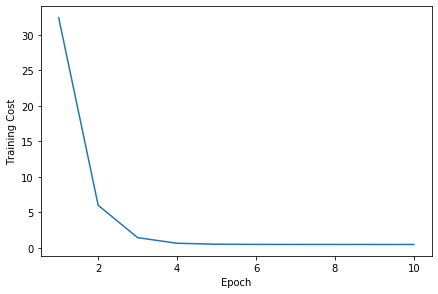

In [25]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(training_costs) + 1), training_costs)
plt.tight_layout()
plt.xlabel('Epoch')
plt.ylabel('Training Cost')
plt.show()

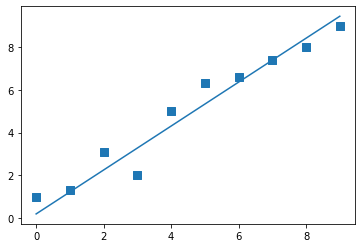

In [26]:
plt.scatter(X_train, Y_train, marker='s', s=50, label='Training Data')
plt.plot(range(X_train.shape[0]), lrmodel.predict(X_train), label = ' LinReg Model')